# Import the Dataset

In this notebook a 3D analysis of the Crab is demonstated. In addition to the usuall model parameters so called 'nuisance parameters' are fitted which account for any systematical uncertainties. These sysetmatical uncertainties are assumed to be due a missmodelling of the hardronic background. 

The nuisance parameters are correlated so they can only eliminate the systemtic uncertainties but not the uncorrelated statistical uncertainicies.  

The notebook is structed as follows:

- Setting up the correlation of the nuisacane parameters
- Fitting the model and the nuisance parameters to the data
- Compare the results to the standard 3D fit

In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 0.20 (18-10-2022)' )

loaded gammapy version: 0.20 
Supposed to be 0.20 (18-10-2022)


In [2]:
#get_ipython().system('jupyter nbconvert --to script 5a-Tutorial_Nui_Par_Fitting_Crab.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit, Parameter, Parameters, Covariance
from gammapy.datasets import MapDataset #, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
)
from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

#sys.path.append(
#    "/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/syserror_3d_bkgmodel/4-Fitting_nuisance_and_model_parameters"
#)
from my_dataset_maps_20 import MapDatasetNuisance
from  my_fit_20 import Fit

## Standard Analysis
Setting up the model

time 2 is hopefully between 0-8
spatial binsize =  [0.02] deg
DatasetModels

Component 0: SkyModel

  Name                      : HESS J1741-302
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                 (frozen):      2.300                   
    amplitude             (frozen):   2.10e-13       1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lon_0                 (frozen):    358.277       deg         
    lat_0                 (frozen):      0.049       deg         

Component 1: SkyModel

  Name                      : HESS J1745-290
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.068   +/-    0.06             
    amplit

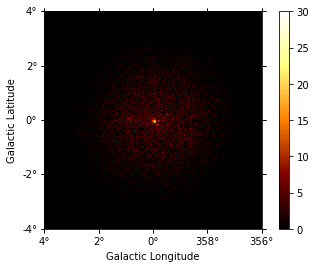

In [3]:
#source = 'GC_dataset_zeta_5_muoneffTrue_edispTrue'
source = 'GC_dataset_zeta_5_muoneffTrue_edisp_True_large_sysamplitude'
source = 'GC_timedependent_'
time = '2'
source = source + time

free_parameters = 'centralspectrumfree' # modelfrozen , centralspectrumfree

path = '/home/vault/caph/mppi062h/repositories/HESS_3Dbkg_syserror/2-error_in_dataset'
local_path = '/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/HESS_3Dbkg_syserror/2-error_in_dataset'


if source == "Crab":

    dataset_standard = MapDataset.read(f'{path}/{source}/stacked.fits')
    dataset_standard = dataset_standard.downsample(4)

    models = Models.read(f"{source}/standard_model.yml")
    
    with open(f"{source}/nui_bgmodel.yml", "r") as ymlfile:
        best_fit_bgmodel = yaml.load(ymlfile, Loader=yaml.FullLoader)
    bkg_model = FoVBackgroundModel(dataset_name=dataset_standard.name)
    bkg_model.parameters['norm'].value = best_fit_bgmodel['spectral']['parameters'][0]['value']
    bkg_model.parameters['tilt'].value = best_fit_bgmodel['spectral']['parameters'][1]['value']
    bkg_model.parameters['norm'].error = best_fit_bgmodel['spectral']['parameters'][0]['error']
    bkg_model.parameters['tilt'].error = best_fit_bgmodel['spectral']['parameters'][1]['error']
    
    models.parameters['lon_0'].frozen = True
    models.parameters['lat_0'].frozen = True
    
    models.append(bkg_model)
    dataset_standard.models = models
    ebins_display = 6,9
    print(dataset_standard)

    
if "GC" in source :
    if source =='GC':
        path_GC ='/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/syserror_3d_bkgmodel/2-source_dataset/GC_0.19'
        dataset_standard = MapDataset.read(f'{path_GC}/20220511_dataset002_hess1_muonflagTrue.fits')
        dataset_standard.stack(MapDataset.read(f'{path_GC}/20220511_dataset002_hess2_muonflagTrue.fits'))
        dataset_standard = dataset_standard.downsample(4)
        
        
        # Define source model for stacked fit
        from gammapy.modeling.models import (PointSpatialModel, 
                                             ExpCutoffPowerLawSpectralModel,
                                             PowerLawSpectralModel,
                                             GaussianSpatialModel,TemplateSpatialModel,
                                            PowerLawNormSpectralModel)
        spatial_model_center = PointSpatialModel(lon_0=359.9439608*u.deg, lat_0=-0.0418969*u.deg, frame='galactic') 
        spectral_model_center = ExpCutoffPowerLawSpectralModel(index=2.14, amplitude="2.55e-12 cm-2 s-1 TeV-1", reference="1 TeV", lambda_='0.093 TeV-1')
        source_model_center = SkyModel(spatial_model=spatial_model_center, spectral_model=spectral_model_center, name="src")

        spatial_model_g09 = PointSpatialModel(lon_0=0.8717549*u.deg, lat_0=0.0767488*u.deg, frame='galactic')
        spectral_model_g09 = PowerLawSpectralModel(index=2.4, amplitude="0.838e-12 cm-2 s-1 TeV-1", reference="1 TeV") # was 3e-12
        source_model_g09 = SkyModel(spatial_model=spatial_model_g09, spectral_model=spectral_model_g09, name="g09")

        spatial_model_1745 = GaussianSpatialModel(lon_0=358.6435538*u.deg, lat_0=-0.5617789*u.deg, sigma=0.179*u.deg, frame='galactic')
        spectral_model_1745 = PowerLawSpectralModel(index=2.57, amplitude="1.73e-12 cm-2 s-1 TeV-1", reference="1 TeV") # 
        source_model_1745 = SkyModel(spatial_model=spatial_model_1745, spectral_model=spectral_model_1745, name="1745")

        spatial_model_1746 = PointSpatialModel(lon_0=0.1384563*u.deg, lat_0=-0.1112664*u.deg, frame='galactic')
        spectral_model_1746 = PowerLawSpectralModel(index=2.17, amplitude="0.18e-12 cm-2 s-1 TeV-1", reference="1 TeV") # was 3e-12
        source_model_1746 = SkyModel(spatial_model=spatial_model_1746, spectral_model=spectral_model_1746, name="1746")

        spatial_model_1746308 = GaussianSpatialModel(lon_0=358.4479799*u.deg, lat_0=-1.1140008*u.deg, sigma=0.162*u.deg, frame='galactic')
        spectral_model_1746308 = PowerLawSpectralModel(index=3.27, amplitude="0.70e-12 cm-2 s-1 TeV-1", reference="1 TeV") #
        source_model_1746308 = SkyModel(spatial_model=spatial_model_1746308, spectral_model=spectral_model_1746308, name="1746308")

        spatial_model_1741 = PointSpatialModel(lon_0=358.2753545*u.deg, lat_0=0.0515537*u.deg, frame='galactic')
        spectral_model_1741 = PowerLawSpectralModel(index=2.30, amplitude="0.21e-12 cm-2 s-1 TeV-1", reference="1 TeV") # was 3e-12
        source_model_1741 = SkyModel(spatial_model=spatial_model_1741, spectral_model=spectral_model_1741, name="1741")

        diffuse_filename = "/home/saturn/caph/mppi043h/diffusiontemplate/cont_pcut_v3.fits"
        diffuse_gal = Map.read(diffuse_filename)
        print(diffuse_gal.geom.axes[0].name)
        template_diffuse = TemplateSpatialModel(
                diffuse_gal, normalize=False,
            filename = diffuse_filename
            )
        diffuse_model = SkyModel(
            spectral_model=PowerLawNormSpectralModel(),
            spatial_model=template_diffuse,
            name="Diffuse Emission",)

        bkg_model = FoVBackgroundModel(dataset_name=dataset_standard.name)
        bkg_model.parameters['tilt'].frozen  = False

        models = Models([source_model_center, source_model_g09, source_model_1745, source_model_1746, 
                         source_model_1746308, source_model_1741, diffuse_model, bkg_model ])

    
    if 'muoneffTrue_edispTrue' in source:
        
        path_GC = '/home/vault/caph/mppi062h/repositories/GC/HESS/datasets_fits'
        if 'large_sysamplitude' in source:
            dataset_standard = MapDataset.read(f'{path_GC}/{source[3:-19]}.fits')
        else:    
            dataset_standard = MapDataset.read(f'{path_GC}/{source[3:]}.fits')
        if free_parameters == 'centralspectrumfree':
            models = Models.read(f'{source}/HESS_fixed_models_centralspectrumfree.yml')
        if free_parameters == 'modelfrozen':
            models = Models.read(f'{source}/HESS_fixed_models.yml')
            
        print(models)
        dataset_standard.models = models


    if 'GC_timedependent' in source:
        if time == 'fulltime':
        
            path_GC = '/home/vault/caph/mppi062h/repositories/GC/20221101/HESS/datasets_fits'
            dataset_standard  =  MapDataset.read(f'{path_GC}/dataset_{time}.fits')
            model_name = '/home/vault/caph/mppi062h/repositories/GC/20221101/HESS/models/all_free_fulltime.yaml'
            models = Models.read(model_name)
            bkg_model = FoVBackgroundModel(dataset_name=dataset_standard.name)
            # set bg model parameters frozen
            bkg_model.parameters['tilt'].frozen  = True
            bkg_model.parameters['norm'].frozen  = True

            models.append(bkg_model)
            dataset_standard.models = models

            #set diffuse emission free:
            dataset_standard.models['diff-emission'].parameters['tilt'].frozen = False
        else:
            print('time', time ,'is hopefully between 0-8')
            path_GC = '/home/vault/caph/mppi062h/repositories/GC/20221101/HESS/datasets_fits'
            dataset_standard  =  MapDataset.read(f'{path_GC}/dataset_{time}.fits')
            # read in the best fit model with the nuisance parameters 
            # From the fulltime analysis
            path_best_fit = '/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/syserror_3d_bkgmodel/2-source_dataset/GC_timedependent_fulltime/'
            best_fit_name = 'nui_model_002_424centralspectrumfree.yml'
            models = Models.read(path_best_fit+ best_fit_name)
            bkg_model = FoVBackgroundModel(dataset_name=dataset_standard.name)
            # set bg model parameters frozen
            bkg_model.parameters['tilt'].frozen  = True
            bkg_model.parameters['norm'].frozen  = True

            models.append(bkg_model)
            dataset_standard.models = models

            #set diffuse emission frozen:
            dataset_standard.models['diff-emission'].parameters['tilt'].frozen = True
            dataset_standard.models['diff-emission'].parameters['norm'].frozen = True
     
        
    j1745_coord = SkyCoord(358.6435538, -0.5617789, unit='deg',frame='galactic')

    skyregion_1745 = RectangleSkyRegion(center=j1745_coord, width=1*u.deg,height=1*u.deg)
    geom_2d = dataset_standard.geoms['geom'].drop('energy')
    dataset_standard.mask_safe.data[:] &= Map.from_geom(geom_2d, 
                                                        data=geom_2d.region_mask([skyregion_1745], 
                                                                                          inside=False).data).data
    dataset_standard.models = models
    ebins_display = 4, 14


dataset_standard.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset_standard.geoms["geom"].width[1] / dataset_standard.geoms["geom"].data_shape[1]
print(
    "spatial binsize = ",
    binsize
)

print(dataset_standard.models)


In [21]:
print(dataset_standard.geoms['geom'])


WcsGeom

	axes       : ['lon', 'lat', 'energy']
	shape      : (400, 400, 24)
	ndim       : 3
	frame      : galactic
	projection : CAR
	center     : 0.0 deg, 0.0 deg
	width      : 8.0 deg x 8.0 deg
	wcs ref    : 0.0 deg, 0.0 deg



In [4]:
%%time
fit_standarad = Fit(store_trace=False)
try:
    result_standarad = fit_standarad.run([dataset_standard])
except:
    print("no free model parameters")

CPU times: user 6.68 s, sys: 24.8 ms, total: 6.71 s
Wall time: 6.72 s


The first two energybins of the dataset are not fitted well ...

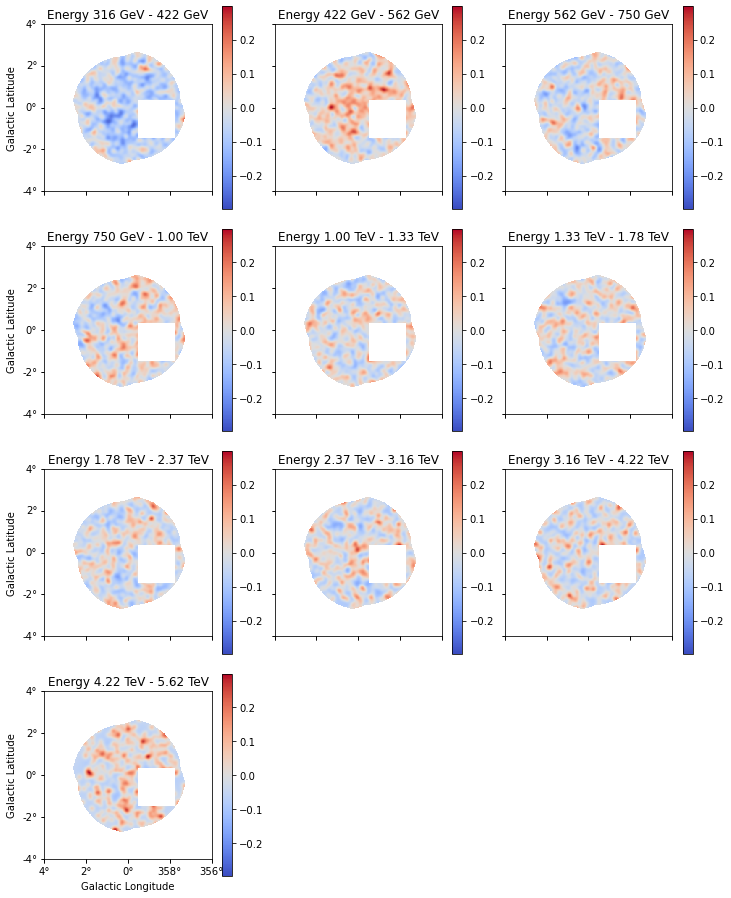

In [5]:
res_standard = (
    dataset_standard.residuals("diff/sqrt(model)")
    .slice_by_idx(dict(energy=slice(ebins_display[0],ebins_display[1] )))
    .smooth(0.1 * u.deg)
)
vmax__ = np.nanmax(np.abs(res_standard.data))

try:
    res_standard.plot_grid(add_cbar=1, vmax=vmax__, vmin=-vmax__, cmap="coolwarm");
    
except:
    res_standard.plot(add_cbar=1, vmax=vmax__, vmin=-vmax__, cmap="coolwarm");
fig = plt.gcf()
#name = f'{source}/plots/res_standard.png'
#fig.savefig(name, dpi=300, bbox_inches = 'tight')

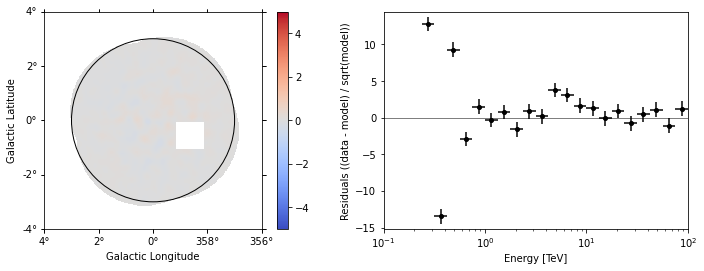

In [6]:
kwargs_spectral = dict()
kwargs_spectral["region"] = CircleSkyRegion(
    dataset_standard.geoms["geom"].center_skydir, radius=3 * u.deg
)
kwargs_spectral["method"] = "diff/sqrt(model)"
dataset_standard.plot_residuals(kwargs_spectral=kwargs_spectral);

## Nuisance Parameters

Firstly, the expected ampitude of the systematics for the different energybins are read. They can either be in terms of std or in percentage of the bg. Since in the end the nuisance parameters are in percentage of bg, we want the amplitude in the same unit..

Here, two things are used to save computation time:
- The nuisance parameters are computed only within the first two energybins of the analysis (index 4 and 5) exemplary to save computation time. The indices are defined as `i_start` and `i_end`. This approximation is fine since the systematic uncertainites are known to be the largest at the smaller energies. 
- The nuisance parameter have a larger binsize than the counts cube. The downsampling factor `downsampling_factor` denotes that. This way, one nuisance parameter acts on multiple neighbor bins and the systematic uncertainty is averaged over them. The geometry of this downsampled nuisance parameter cube is saved in `dataset.geoms['geom_down']`.




### Systematic Amplitude

In [7]:
bg = (
    dataset_standard.background
    .data.sum(axis=2)
    .sum(axis=1)
)

#sysamplitude_std = np.loadtxt(f'{source}/sysamplitude.txt')
# Convert to %:
#sysamplitude_std /= np.sqrt(bg)

if 'GC_timedependent' in source:
    if (time == '7' or time =='8'):
        name = 'from_dataset_' + time + '_percentage.txt'
    else:
        name = 'from_lookuptable_' + time + '_percentage.txt'
    local_path_ = '/home/vault/caph/mppi062h/repositories/GC/20221101/HESS/systematic_levels'
    sysamplitude_percentage = np.loadtxt((f'{local_path_}/{name}'))
    
else:
    sysamplitude_percentage = np.loadtxt((f'{local_path}/{source}/sysamplitude_percentage.txt'))
# Convert to %:
sysamplitude_percentage /= 100
print("sysamplitude_percentage:",sysamplitude_percentage)


#choose between the following:
sigma = sysamplitude_percentage 
#sigma = sysamplitude_std 


emask = sigma >0
print("Estimated systematic uncertainty: ")
print()
print("Ebin               [Counts]    [% BG]")

for i, e in enumerate(dataset_standard.geoms['geom'].axes[0].center.value):
    e_start, e_end = (
        dataset_standard.geoms["geom"].axes[0].edges[ i],
        dataset_standard.geoms["geom"].axes[0].edges[i + 1],
    )
    sys_percent = sigma[i]
    sys_counts =  sigma[i] * bg[i]
    

    print(
        f"{np.round(e_start.value,1):<4} : {np.round(e_end.value,1):<6} TeV:  {np.round(sys_counts,0):<10}  {np.round(sys_percent,3):<5}  "
        )
    
    


sysamplitude_percentage: [ 0.          0.          0.          0.         -0.06588691  0.10020446
 -0.00912376  0.01400535 -0.02350724 -0.01583591 -0.0259855  -0.02430801
 -0.04023127  0.05980081 -0.0251007   0.09762201  0.1012111   0.11763085
  0.1798644   0.1644445   0.          0.          0.          0.        ]
Estimated systematic uncertainty: 

Ebin               [Counts]    [% BG]
0.1  : 0.1    TeV:  0.0         0.0    
0.1  : 0.2    TeV:  0.0         0.0    
0.2  : 0.2    TeV:  0.0         0.0    
0.2  : 0.3    TeV:  0.0         0.0    
0.3  : 0.4    TeV:  -1065.0     -0.066  
0.4  : 0.6    TeV:  1493.0      0.1    
0.6  : 0.7    TeV:  -100.0      -0.009  
0.7  : 1.0    TeV:  111.0       0.014  
1.0  : 1.3    TeV:  -130.0      -0.024  
1.3  : 1.8    TeV:  -60.0       -0.016  
1.8  : 2.4    TeV:  -65.0       -0.026  
2.4  : 3.2    TeV:  -38.0       -0.024  
3.2  : 4.2    TeV:  -40.0       -0.04  
4.2  : 5.6    TeV:  30.0        0.06   
5.6  : 7.5    TeV:  -6.0        -0.025  
7

### Downsampling Factor

In [9]:
angular_size_file = f'{source}/angular_size.txt'
angular_size = np.loadtxt(angular_size_file)
ndim_spatial = dataset_standard.geoms['geom'].data_shape[1]
print("Current Binning:", ndim_spatial)
possible_downsampling_factors = []
possible_binsizes = []
for i in range(1, ndim_spatial):
    if (ndim_spatial%i == 0):
        possible_downsampling_factors.append(i)
        possible_binsizes.append(binsize[0].value * i)


print(f"Possible downsampling factors: {possible_downsampling_factors}")
print(f"Resulting Binsize: {possible_binsizes}")

downsampling_factor_index = -1
while (possible_binsizes[downsampling_factor_index] > angular_size):
    downsampling_factor_index -=1
downsampling_factor =    possible_downsampling_factors[downsampling_factor_index]
binsize_down = possible_binsizes[downsampling_factor_index]
# ##############################
down_hand = 1
if down_hand :
    downsampling_factor = 200
    binsize_down = binsize * downsampling_factor
# ##############################


print()
print(f"Chosen Downsampling Factor: \n {downsampling_factor}.")
print(f"This will result in a Binsize of the Nuisance Parameters of \n {binsize_down} deg.")
print(f"Which is smaller than the observed angular size of the systematics of \n {angular_size} deg.")

geom_down = dataset_standard.downsample(downsampling_factor).geoms['geom']


Current Binning: 400
Possible downsampling factors: [1, 2, 4, 5, 8, 10, 16, 20, 25, 40, 50, 80, 100, 200]
Resulting Binsize: [0.02, 0.04, 0.08, 0.1, 0.16, 0.2, 0.32, 0.4, 0.5, 0.8, 1.0, 1.6, 2.0, 4.0]

Chosen Downsampling Factor: 
 200.
This will result in a Binsize of the Nuisance Parameters of 
 [4.] deg deg.
Which is smaller than the observed angular size of the systematics of 
 1.0 deg.


### Nuisance Mask

The `nuisance_mask` describes where in the dataset the nuisance parameters are evaulated. It has the same geometry as `dataset.geoms['geom_down']`. 

#### Option 1:
define start and stop by hand

In [10]:
i_start, i_end = 4,24
nuisance_mask_hand = (
    dataset_standard.geoms["geom"]
    .energy_mask(
        energy_min=dataset_standard.geoms["geom"].axes[0].edges[i_start],
        energy_max=dataset_standard.geoms["geom"].axes[0].edges[i_end],
    )
    .downsample(downsampling_factor)
)

#### Option 2:
Read in the sysamplitudes and only fit the nuisance parameters where sys amplitude >0

In [11]:
print('Creating Mask for Nuisance Parameters where sysamplitude==0')
nui_mask = np.abs(sigma)>0
print('nui_mask:',nui_mask)
nuisance_mask = Map.from_geom(geom_down, dtype=bool)
for e, n in enumerate(nui_mask):
    nuisance_mask.data[e,:,:] = n
nuisance_mask &= nuisance_mask_hand
emask = nuisance_mask.data.mean(axis=2).mean(axis=1)
emask = list(map(bool,emask))
print(emask)

Creating Mask for Nuisance Parameters where sysamplitude==0
nui_mask: [False False False False  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True False False False False]
[False, False, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, False, False, False]


### Nuisance Parameters

In [12]:
threshold = 1#10000
bg_map_eaxis = dataset_standard.background.data.sum(axis = 2).sum(axis=1)


print("                                     sys * thresh < stat:")
for i in range(len(bg_map_eaxis)):
    stat =np.round(np.sqrt(bg_map_eaxis[i]) )
    sys = np.round(np.abs(sigma[i]*bg_map_eaxis[i]))
    print(f"BG: {np.round(bg_map_eaxis[i]):<10} pm {stat:<14}   |  {sys}")
    print(f" { ((sys * threshold) < stat):>60}")

                                     sys * thresh < stat:
BG: 0.0        pm 0.0              |  0.0
                                                            0
BG: 0.0        pm 0.0              |  0.0
                                                            0
BG: 0.0        pm 0.0              |  0.0
                                                            0
BG: 6976.0     pm 84.0             |  0.0
                                                            1
BG: 16159.0    pm 127.0            |  1065.0
                                                            0
BG: 14903.0    pm 122.0            |  1493.0
                                                            0
BG: 10943.0    pm 105.0            |  100.0
                                                            1
BG: 7951.0     pm 89.0             |  111.0
                                                            0
BG: 5527.0     pm 74.0             |  130.0
                                                        

In [13]:
for ii in np.arange(len(sigma)):
    print( np.abs(sigma[ii]) >0.0 , emask[ii])


False False
False False
False False
False False
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
False False
False False
False False
False False


In [14]:
# new way to compute correlation matrix to make it symmetric/ invertible
# into Gaussian: sigma **2  * exp(...), where sigma  is the systematic amplitude in %
# if it is saved in terms of std it has to be transformed! 
ndim_spectral_nui = int(sum(emask))
ndim_spatial_nui_1D = geom_down.data_shape[1]
ndim_spatial_nui = ndim_spatial_nui_1D **2
ndim_3D_nui = ndim_spectral_nui *  ndim_spatial_nui

sys_map = Map.from_geom(geom_down).slice_by_idx(dict(energy=slice(0,int(ndim_spectral_nui))))
e = 0
sys_map.data = np.ones_like(sys_map.data)
for ii in np.arange(len(sigma)):
    if np.abs(sigma[ii]) >0.0 and emask[ii]:
        if dataset_standard.npred_background().downsample(downsampling_factor).data[ii,:,:].sum() > 0:
            sys_map.data[e,:,:] *= sigma[ii] **2
            print(sigma[ii])
        e+=1



-0.0658869052145743
0.10020446443487999
-0.00912376358161885
0.01400534816134431
-0.023507235641545304
-0.015835913986168213
-0.025985498923106733
-0.024308013472333346
-0.04023127001844071
0.0598008085300358
-0.02510070019967401
0.09762200863111792
0.10121109973453832
0.11763085124305027
0.1798644019093177
0.16444450389267792


In [15]:
# Freeze Nuisance parameters at the edges of the analysis
threshold = 1
bg_map  = dataset_standard.background.downsample(downsampling_factor)
bg = bg_map.data[emask].flatten()
stat_err_ = np.sqrt(bg)
Nuisance_parameters = [Parameter(name = "db"+str(i), value =0,frozen = False)  
            if sys_map.data.flatten()[i]  * threshold < stat_err_[i] 
            else  Parameter(name = "db"+str(i), value = 0,frozen = True)
      for i in range(ndim_3D_nui)]
ii = 0
for i in Nuisance_parameters:
    if i.frozen == False:
        ii += 1
print(ii, ' free Nuisance Parameters out of ', ndim_3D_nui)
Nuisance_parameters = Parameters( Nuisance_parameters)
print(ii, '/ ', ndim_3D_nui)



64  free Nuisance Parameters out of  64
64 /  64


The total amount of nuisance parameters in the dataset can now be computed (defined as `ndim_3D_nui`). The number of spatial and spectral dimensions of the nuisance parameter cube is defined as `ndim_spatial_nui` and `ndim_spectral_nui` since it is needed for the computation of the correlation matrix. Note that here the FoV is expected to be squared. 
The nuisance parameters are defined with their initial value set to `0`.

## Correlation of Nuisance Parameters

The Gaussian correlation matrix is the kronecker product of the spatial $K_{ij}$ and the spectral correlation matrix $K_{e}$: \
$ K_{ije} = K_{e} \cdot K_{ij} $

The spatial correlation matrix is defined as follows:

$K_{ij} = \exp \left( \frac{ -  (r_i - r_j ) ^2} {2\cdot l_{corr}^2}    \right)$,\
where $l_{corr}$ describes the spatial correlation length. Note that the correlation amplitude in the spatial correlation matrix is set to $1$. This is due to the fact, that we assume in the first order a uniformly distributed systematic uncertainty over the FoV. The correaltion amplitude was evaluated over the summed up FoV for each of the energybins and is therefore used in the spectral correlation desciption only.

The spectral correaltion matrix is:

$K_{s} = \sigma_s $, \
where $\sigma_s$ is the correlation amplitude in the spectral bin $s$. Note that here the correlation is in fact not Gaussian and there is no correlation between the energy bins. The correaltion is intrinsically included in the way the spectral correlation amplitude is defined. 


Therefor for the Gaussian correlation matrix $K_{ije}$ of the nuisance parameter one needs two parameters:
- `l_corr`: the spatial correlation length in deg. For instance, a Fourier transformation of the residual map of the standard analysis can be used to estimate the correlation length. Generally, it is important to choose a correaltion length greater than the bin size of the counts cube to avoid fitting the nuisance parameters without any correlation which can lead to overfitting the data. 
- `sysamplitude`: list of correlation amplitudes for the different energybins. The strength of the systematics can be estimated of the spectral residual points when taking only the OFF regions of all runs into account. Here, these obtained values are divided by the amount of spatial bins they were computed for.   

In [16]:
l_corr = 0.08


The spatial correlation matrix is computed with two helper maps to compute the separation angle between two spatial bins. Afterwards, the systematic amplitude is set as the diagonal of the spectral correlation matrix and the kroneker product of the two is returned as the overall correlation matrix. 

In [17]:
geom_down = nuisance_mask.geom
helper_map = Map.from_geom(geom_down).slice_by_idx(dict(energy=slice(0, 1)))
helper_map2 = helper_map.copy()


def compute_K_matrix(l_deg):
    corr_matrix_spatial = np.identity(ndim_spatial_nui)
    for b_0 in range(ndim_spatial_nui_1D):
        for l_0 in range(ndim_spatial_nui_1D):
            i = b_0 * ndim_spatial_nui_1D + l_0
            C = SkyCoord(
                helper_map.geom.pix_to_coord((l_0, b_0, 0))[0],
                helper_map.geom.pix_to_coord((l_0, b_0, 0))[1],
                frame=geom_down.frame,
            )
            helper_map.data[0, :, :] = C.separation(
                geom_down.to_image().get_coord().skycoord
            ).value
            helper_map2.data = np.zeros(ndim_spatial_nui_1D ** 2).reshape(
                helper_map2.geom.data_shape
            )
            helper_map2.data[0, :, :] = np.exp(
                -0.5 * helper_map.data[0, :, :] ** 2 / l_deg ** 2
            )
            corr_matrix_spatial[i, :] = helper_map2.data.flatten()

    corr_matrix_spectral = np.identity(ndim_spectral_nui)
    for e in range((ndim_spectral_nui)):
        corr_matrix_spectral[e, e] = sigma[emask][e] ** 2
    return np.kron(corr_matrix_spectral, corr_matrix_spatial)

In [18]:
l_corr

0.08

Maximal expected sys amplitude in % of bg: 17.98644019093177
Maximal sigma: 17.98644019093177


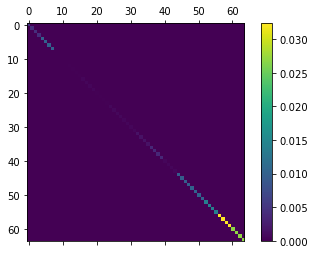

In [19]:
correlation_matrix = compute_K_matrix(l_corr)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlation_matrix)  # interpolation='nearest')
fig.colorbar(cax);
print("Maximal expected sys amplitude in % of bg:", np.sqrt(correlation_matrix.max() ) * 100)
print("Maximal sigma:", sigma[emask].max()* 100)

#name = f'plots/Example_corr_matrix.png'
#fig.savefig(name, dpi=300, bbox_inches = 'tight')

# Initiate the MapDatasetNuisance

The MapDatasetNuisance class takes in addition to the MapDataset class:
- `inv_corr_matrix`: The inverse of the correlation matrix 
- ` N_parameters`: The nuisance parameters
- `nuisance_mask`: Mask to help evaluating the nuisance parameters in the background prediction

In [20]:
dataset_N = MapDatasetNuisance(
    background=dataset_standard.background,
    exposure=dataset_standard.exposure,
    psf=dataset_standard.psf,
    edisp=dataset_standard.edisp,
    mask_fit=dataset_standard.mask_fit,
    mask_safe=dataset_standard.mask_safe,
    counts=dataset_standard.counts,
    inv_corr_matrix=np.linalg.inv(correlation_matrix),
    N_parameters=Nuisance_parameters,
    nuisance_mask=nuisance_mask,
)


## important!!! the background parameters are unfrozen here!!!!

if 'GC_timedependent' in source:
    if time == 'fulltime':
        
        model_name = '/home/vault/caph/mppi062h/repositories/GC/20221101/HESS/models/all_free_fulltime.yaml'
        models_N = Models.read(model_name)
        bkg_model_N = FoVBackgroundModel(dataset_name=dataset_N.name)
        # set bg model parameters frozen
        bkg_model_N.parameters['tilt'].frozen  = True
        bkg_model_N.parameters['norm'].frozen  = True

        models_N.append(bkg_model_N)
        dataset_N.models = models_N

        #set diffuse emission free:
        dataset_N.models['diff-emission'].parameters['tilt'].frozen = False
    else:
        models_N = Models(dataset_standard.models.copy())
        bkg_model_N = FoVBackgroundModel(dataset_name=dataset_N.name)
        # set bg model parameters frozen
        bkg_model_N.parameters['tilt'].frozen  = True
        bkg_model_N.parameters['norm'].frozen  = True
        models_N.append(bkg_model_N)
        dataset_N.models= models_N
else:
    bkg_model = FoVBackgroundModel(dataset_name=dataset_N.name)
    bkg_model.parameters["tilt"].frozen = False
    models_N = models.copy()
    models_N.append(bkg_model)
    dataset_N.models = models_N 

    
dataset_N.npred_background()
print(dataset_N)
print(dataset_N.models)

error: (mx>kx) failed for hidden mx: regrid_smth:mx=2

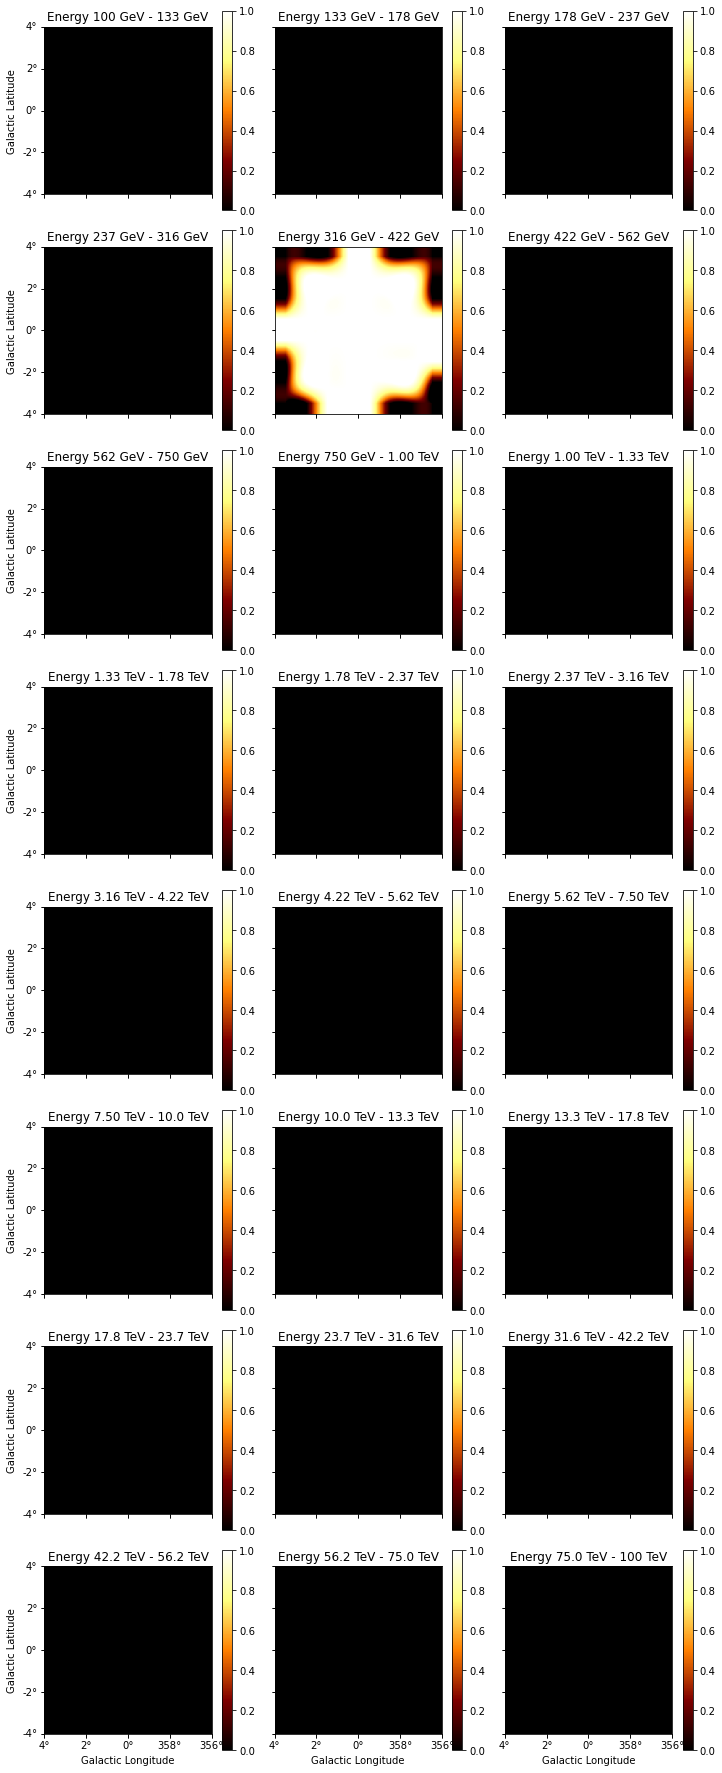

In [28]:
## Check the mask:
Nuisance_parameters_check = Nuisance_parameters.copy()
for N in Nuisance_parameters_check.free_parameters:
    N.value = 1
dataset_N.N_parameters = Nuisance_parameters_check
dataset_N.N_map().plot_grid(add_cbar =1, vmin = 0, vmax = 1);

dataset_N.N_parameters = Nuisance_parameters

fig = plt.gcf()
name = f'{source}/plots/nuisance_mask.png'
fig.savefig(name, dpi=300, bbox_inches = 'tight')

## Running the Fit

In [21]:
%%time
fit_N = Fit(store_trace=False)
result_N = fit_N.run([dataset_N])

CPU times: user 2min 5s, sys: 78.9 ms, total: 2min 5s
Wall time: 2min 6s


The method `N_map()` is a map in the origial geometry with the nuisance parameters as the data. It is used in npred_background() and visualises the best fit nuisance parameters.

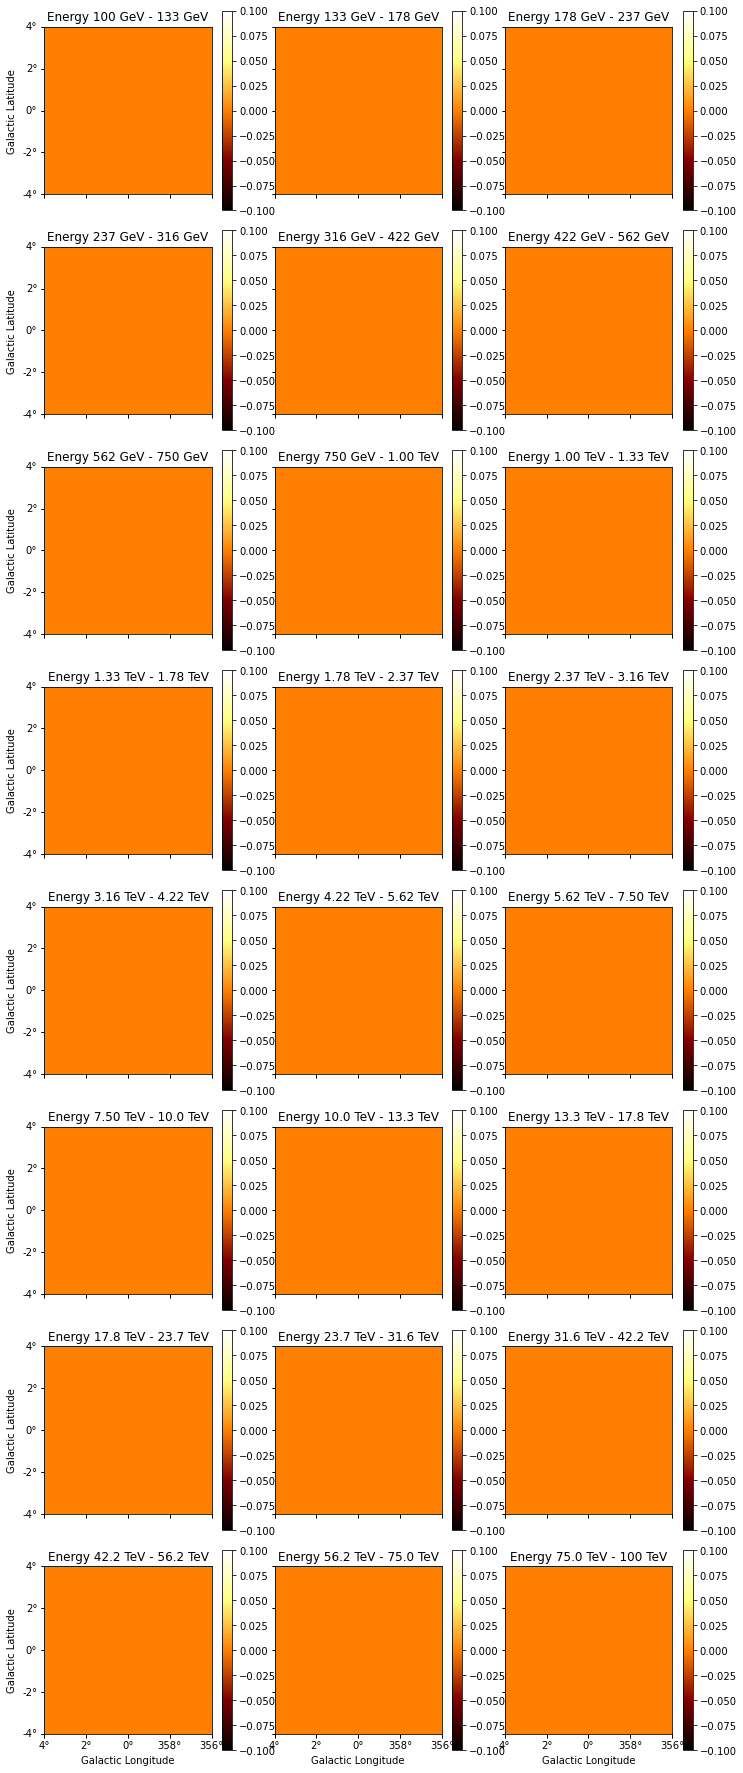

In [29]:
vmax = np.max(np.abs(dataset_N.N_map().data))
dataset_N.N_map().plot_grid(
    add_cbar=1, vmax=vmax, vmin=-vmax
);

fig = plt.gcf()
name = f'{source}/plots/best_fit_nuis.png'
fig.savefig(name, dpi=300, bbox_inches = 'tight')

## Comparison to Standard Analysis

The spectral residual points show again how especially the first two energybins are not fitted well

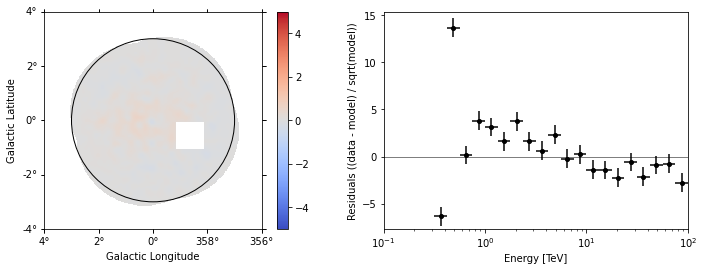

In [23]:
dataset_standard.plot_residuals(kwargs_spectral=kwargs_spectral);

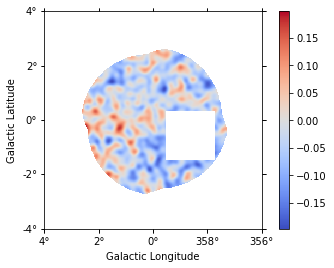

In [24]:
res_standard = (
    dataset_standard.residuals("diff/sqrt(model)")
    .slice_by_idx(dict(energy=slice(i_start, i_end)))
    .smooth(0.1 * u.deg)
)
vmax__ = np.nanmax(np.abs(res_standard.data))

try:
    res_standard.plot_grid(add_cbar=1, vmax=vmax__, vmin=-vmax__, cmap="coolwarm");
except:
    res_standard.plot(add_cbar=1, vmax=vmax__, vmin=-vmax__, cmap="coolwarm");

fig = plt.gcf()
name = f'{source}/plots/res_standard.png'
fig.savefig(name, dpi=300, bbox_inches = 'tight')

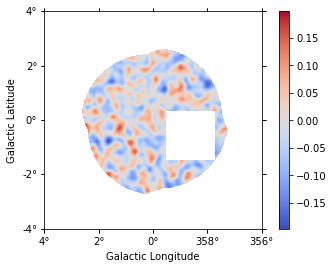

In [25]:
res_N = (
    dataset_N.residuals("diff/sqrt(model)")
    .slice_by_idx(dict(energy=slice(i_start, i_end)))
    .smooth(0.1 * u.deg)
)

try:
    res_N.plot_grid(add_cbar=1, vmax=vmax__, vmin=-vmax__, cmap="coolwarm");
except:
    res_N.plot(add_cbar=1, vmax=vmax__, vmin=-vmax__, cmap="coolwarm");

fig = plt.gcf()
name = f'{source}/plots/res_N.png'
fig.savefig(name, dpi=300, bbox_inches = 'tight')

After including the nuisance parameters the model description is much better in the first two energy bins. This indicates that the method worked and has improved out analysis.

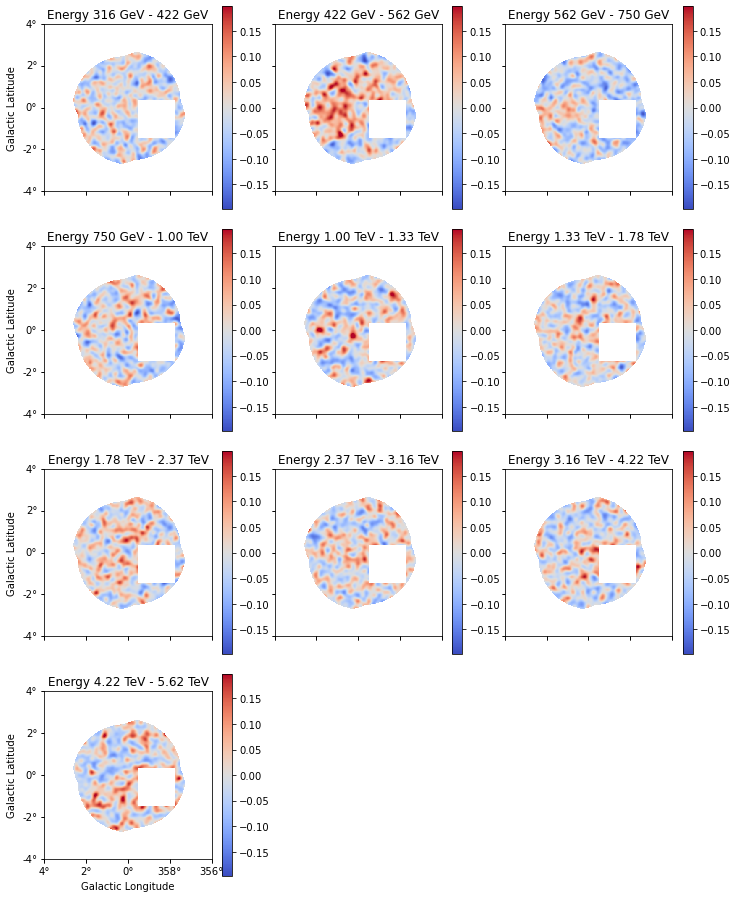

In [26]:
res_N = (
    dataset_N.residuals("diff/sqrt(model)")
    .slice_by_idx(dict(energy=slice(ebins_display[0],ebins_display[1] )))
    .smooth(0.1 * u.deg)
)
vmax = np.nanmax(np.abs(res_standard.data))
res_N.plot_grid(add_cbar=1, vmax=vmax, vmin=-vmax, cmap="coolwarm");

/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/HESS_3Dbkg_syserror/2-error_in_dataset/my_dataset_maps_20.py:1014: RuntimeWarning: invalid value encountered in true_divide
  yerr = excess_error / np.sqrt(npred_spec.data)


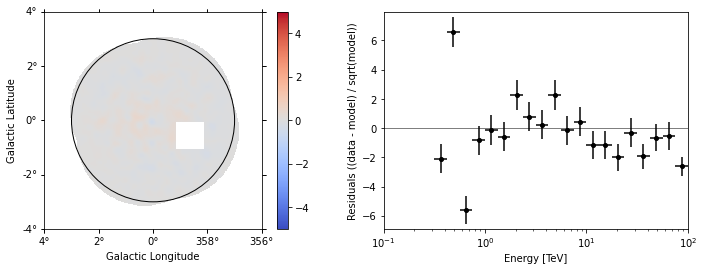

In [27]:
dataset_N.plot_residuals(kwargs_spectral=kwargs_spectral);

Her a comparison of the distribution of the significance maps in the first two energy bins is shown. With the nuisance parameters the mean of the distribution $\mu$ got closer to zero and the standard deviation $\sigma$ is closer to the expected $1$.

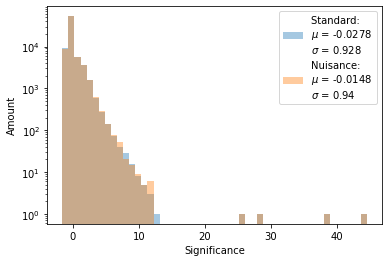

In [28]:
res_standard = (
    dataset_standard.residuals("diff/sqrt(model)")
    .slice_by_idx(dict(energy=slice(i_start, i_end)))
    .data.flatten()
)
res_N = (
    dataset_N.residuals("diff/sqrt(model)")
    .slice_by_idx(dict(energy=slice(i_start, i_end)))
    .data.flatten()
)

_, bins, _ = plt.hist(
    res_standard,
    bins=50,
    alpha=0.4,
    label="Standard: \n$\mu$ = {:.3} \n$\sigma$ = {:.3}".format(
        np.nanmean(res_standard), np.nanstd(res_standard)
    ),
)
plt.hist(
    res_N,
    bins=bins,
    alpha=0.4,
    label="Nuisance: \n$\mu$ = {:.3} \n$\sigma$ = {:.3}".format(
        np.nanmean(res_N), np.nanstd(res_N)
    ),
)
plt.yscale("log")
plt.legend()
plt.xlabel("Significance")
plt.ylabel("Amount");

/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/HESS_3Dbkg_syserror/2-error_in_dataset/my_dataset_maps_20.py:1014: RuntimeWarning: invalid value encountered in true_divide
  yerr = excess_error / np.sqrt(npred_spec.data)


[1.00000000e-01 1.33352143e-01 1.77827941e-01 2.37137371e-01
 3.16227766e-01 4.21696503e-01 5.62341325e-01 7.49894209e-01
 1.00000000e+00 1.33352143e+00 1.77827941e+00 2.37137371e+00
 3.16227766e+00 4.21696503e+00 5.62341325e+00 7.49894209e+00
 1.00000000e+01 1.33352143e+01 1.77827941e+01 2.37137371e+01
 3.16227766e+01 4.21696503e+01 5.62341325e+01 7.49894209e+01
 1.00000000e+02]


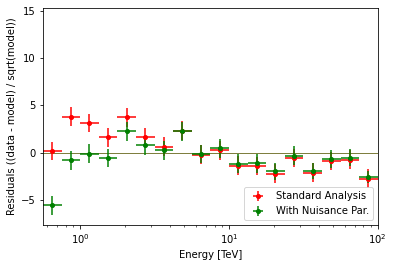

In [29]:
fig = plt.figure()
ax = dataset_standard.plot_residuals_spectral(method = kwargs_spectral["method"],
                                    region = kwargs_spectral["region"],
                                        color = 'red',
                                        label = "Standard Analysis")
ylim = ax.get_ylim()
dataset_N.plot_residuals_spectral(ax = ax ,method = kwargs_spectral["method"],
                                    region = kwargs_spectral["region"],
                                         color = 'green',
                                         label = "With Nuisance Par.")
ax.set_ylim(ylim[0], ylim[1])
eax = dataset_standard.geoms['geom'].axes[0].edges.value
print(eax)
ax.set_xlim(eax[6], eax[-1])
ax.legend(loc = 'lower right')

name = f'plots/2_Spectral_Residuals.png'
fig.savefig(name, dpi=300, bbox_inches = 'tight')
name = f'plots/2_Spectral_Residuals.pdf'
fig.savefig(name, dpi=300, bbox_inches = 'tight')

## Comparsion of the erros of the best fit model parameters

The model errors of the Nuisance dataset have for now to be set by hand. 

## Pseudo Dataset

In [30]:
dataset_pseudo = dataset_standard.copy()
dataset_pseudo.background = dataset_N.npred_background().copy()
bkg_model = FoVBackgroundModel(dataset_name=dataset_pseudo.name)
bkg_model.parameters["norm"].frozen = True
models_pseudo = models.copy()
models_pseudo.append(bkg_model)
dataset_pseudo.models = models_pseudo

fit_pseudo = Fit(store_trace=False)
try:
    result_pseudo = fit_pseudo.run([dataset_pseudo])
except:
    print("no free parameters")
print(dataset_pseudo)

no free parameters
MapDataset
----------

  Name                            : HyzHA_Ep 

  Total counts                    : 115098 
  Total background counts         : 110781.02
  Total excess counts             : 4316.98

  Predicted counts                : 115122.90
  Predicted background counts     : 110781.02
  Predicted excess counts         : 4341.88

  Exposure min                    : 2.37e+00 m2 s
  Exposure max                    : 4.10e+10 m2 s

  Number of total bins            : 3840000 
  Number of fit bins              : 1472580 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 511714.81

  Number of models                : 8 
  Number of parameters            : 44
  Number of free parameters       : 0

  Component 0: SkyModel
  
    Name                      : HESS J1741-302
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : PointSpatialModel
    Temporal model type    

In [31]:
print(dataset_standard.models)

DatasetModels

Component 0: SkyModel

  Name                      : HESS J1741-302
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                 (frozen):      2.300                   
    amplitude             (frozen):   2.10e-13       1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lon_0                 (frozen):    358.277       deg         
    lat_0                 (frozen):      0.049       deg         

Component 1: SkyModel

  Name                      : HESS J1745-290
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                 (frozen):      2.078                   
    amplitude             (frozen):   1.94e-12       1 / (cm2 s TeV)
    referen

In [32]:
print(" with nuisance")
print("(without nuisance)")

for p_N, p_stand , p_pseudo in zip(dataset_N.models.parameters,
                                   dataset_standard.models.parameters,
                                  dataset_pseudo.models.parameters):
    print()
    print('='*50)
    print(p_N.name , p_N.frozen)
    print('-'*50)
    print(" {:.4} +- {:.3} +- {:.3}".format(p_N.value, float(p_pseudo.error) ,
                                            float(p_N.error)- float(p_pseudo.error)  )   ) 
    print('({:.4} +- {:.3})'.format(p_stand.value, float(p_stand.error) ))




 with nuisance
(without nuisance)

index True
--------------------------------------------------
 2.3 +- 0.2 +- -0.2
(2.3 +- 0.2)

amplitude True
--------------------------------------------------
 2.1e-13 +- 4e-14 +- -4e-14
(2.1e-13 +- 4e-14)

reference True
--------------------------------------------------
 1.0 +- 0.0 +- 0.0
(1.0 +- 0.0)

lon_0 True
--------------------------------------------------
 358.3 +- 0.0 +- 0.0
(358.3 +- 0.0)

lat_0 True
--------------------------------------------------
 0.04908 +- 0.0 +- 0.0
(0.04908 +- 0.0)

index True
--------------------------------------------------
 2.078 +- 0.0473 +- -0.0473
(2.078 +- 0.0473)

amplitude True
--------------------------------------------------
 1.94e-12 +- 6.9e-14 +- -6.9e-14
(1.94e-12 +- 6.9e-14)

reference True
--------------------------------------------------
 1.0 +- 0.0 +- 0.0
(1.0 +- 0.0)

lambda_ True
--------------------------------------------------
 0.09767 +- 0.0162 +- -0.0162
(0.09767 +- 0.0162)

alpha Tru

In [21]:
added =  '00'+str(int(binsize[0].value* 100)) + '_' + str(i_start) + str(i_end)
if down_hand :
    added += "_down" +str(downsampling_factor)
print(added)
    

002_424_down100


In [34]:
import yaml
save = 1
path_local_repo = '/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/syserror_3d_bkgmodel/2-source_dataset'


if save:
    print(f"save in: {path_local_repo}/{source}/nui_dataset_{added}{free_parameters}.fits" )
    print(f"and: {path_local_repo}/nui_bgmodel_{added}{free_parameters}.yml ")


    # save for now in this folder
    dataset_N.write(f'{path_local_repo}/{source}/nui_dataset_{added}{free_parameters}.fits', overwrite = True)
    with open(f'{path_local_repo}/{source}/nui_par_{added}{free_parameters}.yml', 'w') as outfile:
            yaml.dump(dataset_N.N_parameters.to_dict(), outfile, default_flow_style=False,
                     )
    with open(f'{path_local_repo}/{source}/nui_bgmodel_{added}{free_parameters}.yml', 'w') as outfile:
            yaml.dump(dataset_N.background_model.to_dict(), outfile, default_flow_style=False,
                     )
    with open(f'{path_local_repo}/{source}/nui_model_{added}{free_parameters}.yml', 'w') as outfile:
            yaml.dump(dataset_N.models.to_dict(), outfile, default_flow_style=False,
                     )        

    with open(f'{path_local_repo}/{source}/pseudo_bgmodel_{added}{free_parameters}.yml', 'w') as outfile:
            yaml.dump(dataset_pseudo.background_model.to_dict(), outfile, default_flow_style=True)
    with open(f'{path_local_repo}/{source}/pseudo_model_{added}{free_parameters}.yml', 'w') as outfile:
            yaml.dump(dataset_pseudo.models.to_dict(), outfile, default_flow_style=True)    


save in: /home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/syserror_3d_bkgmodel/2-source_dataset/GC_dataset_zeta_5_muoneffTrue_edispTrue/nui_dataset_002_45modelfrozen.fits
and: /home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/syserror_3d_bkgmodel/2-source_dataset/nui_bgmodel_002_45modelfrozen.yml 


Template file already exits, and overwrite is False
Template file already exits, and overwrite is False
